In [1]:
import numpy as np
import pandas as pd
import glob

import matplotlib.pyplot as plt
%matplotlib inline
import os


## Выполнил Широков Александр, ПМ-1701


In [2]:
directory = 'data/*.csv' 
files = glob.glob(directory)[0]
files

'data\\the-total-generation-of-electric.csv'

In [3]:
df = pd.read_csv(files, index_col=0, parse_dates=True)
df = df.fillna(0)
df.head()

The total generation of electricity by the U.S. electric industry (monthly data for the period Jan. 1985 ? Oct. 1996) For recent data, click here
Month                                                                                                                                                        
1985-01-01                                             227.86                                                                                                
1985-02-01                                             198.24                                                                                                
1985-03-01                                             194.97                                                                                                
1985-04-01                                             184.88                                                                                                
1985-05-01                                             196.79

In [4]:
df.columns  = ['The total generation of electricity']
df.head(3)

The total generation of electricity
Month                                          
1985-01-01                               227.86
1985-02-01                               198.24
1985-03-01                               194.97

In [5]:
df.shape

(142, 1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 1985-01-01 to 1996-10-01
Data columns (total 1 columns):
The total generation of electricity    142 non-null float64
dtypes: float64(1)
memory usage: 2.2 KB


In [7]:
df.describe()

The total generation of electricity
count                           142.000000
mean                            231.089366
std                              24.372480
min                             184.880000
25%                             214.212500
50%                             226.730000
75%                             246.252500
max                             304.710000

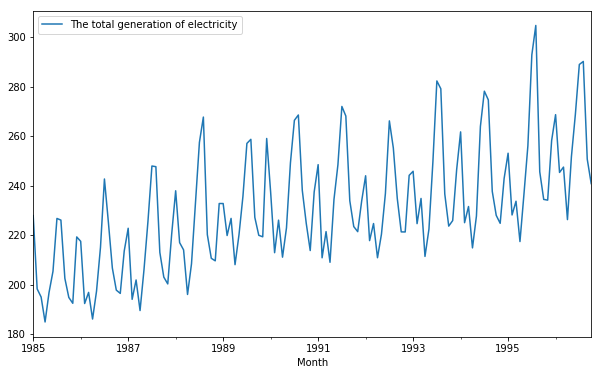

In [8]:
df.plot(figsize=(10, 6))

## 2

**Предположение по графику временного ряда:** виден повышающийся тренд, также на есть годовая сезонность, но начинающаяся не с начала года, а немного после ( примерно через месяца 3) (смотрел на пики колебаний сверху) - максимум приходится на февраль-март, а минимумы призожятся на начало года. 

## 3

Ряд не является стационарным, так как ряд обладает свойством сезонности $\Rightarrow$ распределение будет разным, изменяя положение (ширину) окна.

Следовательно, данный ряд нужно преобразовать. Воспользуемся двумя различными методами:

### 3а. Преобразование Бокса-Кокса

In [9]:
from math import log,exp

data = [x for x in range(1, 10)]

Так выглядит преобразование Бокса-Кокса, задаваемое следующей функцией:
$$ y^{(\lambda)} = 
\left\{
\begin{matrix}
\frac{y^{\lambda}-1}{\lambda}, \lambda \neq 0 \\
\ln y, \lambda = 0
\end{matrix} \right. $$

Параметр $\lambda$ можно найти с помощью метода максимального правдоподобия:
$$ L = \prod_{i=1}^{T} {\frac{1}{\sqrt{2\pi}\cdot \sigma}} \cdot \exp \left ( {-\frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)})^2}}{\sigma^2}}\right) \cdot J(\lambda,y) \to \max $$

Прологорифмируем:
$$ \ln L = \sum_{i=1}^{T} \left ( \ln \frac{1}{\sqrt{2\pi}\cdot \sigma}  - \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)})^2} }{2\sigma^2} + \ln J(\lambda,y) \right )  $$

Воспользуемся оценкой выборочной дисперсии:
$$ \hat{\sigma}^2 = \sum_{i=1}^{T} \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)}})^2}{T} $$
$$ \ln \frac{1}{\sqrt{2\pi \sigma^2}} = \ln \frac{1}{\sqrt{2\pi}} + \ln \frac{1}{\sqrt {\sigma^2}} = \ln \frac{1}{\sqrt{2\pi}} - \ln \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)}})^2}{T}$$ 

Тогда:
$$ \ln L = \sum_{i=1}^{T} \ln \frac{1}{\sqrt{2\pi}} - \ln \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)}})^2}{T} - \frac{T}{2} + \log \prod_{i=1}^{T} y_{i}^{\lambda - 1} = $$ 
$$ = \sum_{i=1}^{T} \ln \frac{1}{\sqrt{2\pi}} - \sum_{i=1}^{T} \ln \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)}})^2}{T} - \frac{T}{2} + (\lambda - 1) \sum_{i=1} \ln y_{i} = -\frac{T}{2} \cdot \ln \sum_{i=1}^{T} \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)}})^2}{T} + (\lambda - 1) \sum_{i=1} \ln y_{i} $$

Итого: логафрим функции правдоподобия Бокса-Кокса:

$$ \ln L = -\frac{T}{2} \cdot \ln \sum_{i=1}^{T} \frac{({y_i^{(\lambda)} - \overline{y}^{(\lambda)}})^2}{T} + (\lambda - 1) \sum_{i=1} \ln y_{i} $$

где $$\overline{y}^{(\lambda)} = \frac{1}{T} \sum y_i^{(\lambda)} $$

$ T $ - количество элементов в выборке.


Взяв производную по параметру $\lambda$ и прировняв к нулю, найдем решение, получим оценку методом максимального правдоподобия.

Попытаемся реализовать данный метод.

In [10]:
def boxcox2(lmbda, x):
    if lmbda == 0:
        return log(x)
    
    return (x**(lmbda) - 1) / lmbda

In [11]:
def likelyhood(lmbda,data):
    #Посчитаем среднее значение преобразования Бокса-Кокса
    sredn = np.sum([boxcox2(lmbda,x) for x in data]) / len(data)
    #Сумма отклонений
    sums = np.sum(([boxcox2(lmbda,x) for x in data] - sredn)**2)
    #Логафрим функции правдоподобия, взятый с обратным знаком, чтобы минимизировать, 
    #а не максимизировать функцию
    ln_L = -(np.sum([log(x) for x in data])*(lmbda - 1) - len(data)/2 * log(sums/len(data)))
    return ln_L

In [12]:
from scipy.optimize import minimize

In [13]:
?minimize

In [14]:
res = minimize(likelyhood,args = data,x0=0)
result = res.x[0]

result

0.7200338917347512

In [15]:
our_result =np.array([boxcox2(result,x) for x in data])
our_result

array([0.        , 0.89887537, 1.67448357, 2.37952151, 3.03633827,
       3.65711941, 4.24945197, 4.81847253, 5.36786672])

Проверим для пробной выборки с помощью написанного метода 'skipy.boxcox' наши результаты

In [16]:
from scipy.stats import boxcox
result_boxcox, lambda_real = boxcox(data)

In [17]:
lambda_real

0.7200338588580096

In [18]:
result_boxcox

array([0.        , 0.89887536, 1.67448353, 2.37952145, 3.03633818,
       3.65711928, 4.2494518 , 4.81847233, 5.36786648])

### Метод реализован нами правильно! Посмотрим, что получилось с данными.

In [19]:
e = np.random.uniform(0.0, 1.0, (100,100))

Проведем кросс-валидацию и узнаем значение параметра $\lambda $

In [20]:
my_lambda = np.array([minimize(likelyhood,args = r,x0=0).x[0] for r in e]).mean()

In [21]:
our_data = df['The total generation of electricity'].values

our_data

array([227.86, 198.24, 194.97, 184.88, 196.79, 205.36, 226.72, 226.05,
       202.5 , 194.79, 192.43, 219.25, 217.47, 192.34, 196.83, 186.07,
       197.31, 215.02, 242.67, 225.17, 206.69, 197.75, 196.43, 213.55,
       222.75, 194.03, 201.85, 189.5 , 206.07, 225.59, 247.91, 247.64,
       213.01, 203.01, 200.26, 220.5 , 237.9 , 216.94, 214.01, 196.  ,
       208.37, 232.75, 257.46, 267.69, 220.18, 210.61, 209.59, 232.75,
       232.75, 219.82, 226.74, 208.04, 220.12, 235.69, 257.05, 258.69,
       227.15, 219.91, 219.3 , 259.04, 237.29, 212.88, 226.03, 211.07,
       222.91, 249.18, 266.38, 268.53, 238.02, 224.69, 213.75, 237.43,
       248.46, 210.82, 221.4 , 209.  , 234.37, 248.43, 271.98, 268.11,
       233.88, 223.43, 221.38, 233.76, 243.97, 217.76, 224.66, 210.84,
       220.35, 236.84, 266.15, 255.2 , 234.76, 221.29, 221.26, 244.13,
       245.78, 224.62, 234.8 , 211.37, 222.39, 249.63, 282.29, 279.13,
       236.6 , 223.62, 225.86, 246.41, 261.7 , 225.01, 231.54, 214.82,
      

In [23]:
res = minimize(likelyhood,args = our_data,x0=0)
result = res.x[0]

result

0.0

In [22]:
boxcox(our_data)

(array([1.01751351, 1.01677546, 1.01668039, 1.0163661 , 1.01673369,
        1.01697209, 1.01748863, 1.0174739 , 1.01689475, 1.01667507,
        1.01660434, 1.01731931, 1.01727726, 1.01660161, 1.01673485,
        1.01640492, 1.01674874, 1.01721826, 1.01781565, 1.01745441,
        1.01700733, 1.01676141, 1.01672322, 1.01718222, 1.01740004,
        1.01665248, 1.01687687, 1.01651412, 1.01699096, 1.01746373,
        1.017914  , 1.01790903, 1.01716886, 1.01690869, 1.01683265,
        1.01734843, 1.0177224 , 1.01726461, 1.01719355, 1.01671067,
        1.01705121, 1.01761747, 1.01808306, 1.01825091, 1.01734101,
        1.01710865, 1.01708265, 1.01761747, 1.01761747, 1.01733263,
        1.01748907, 1.01704265, 1.01733961, 1.01767793, 1.01807605,
        1.01810393, 1.01749804, 1.01733472, 1.01732048, 1.01810984,
        1.01771021, 1.01716563, 1.01747346, 1.01712029, 1.01740367,
        1.01793722, 1.01823013, 1.01826413, 1.01772479, 1.01744372,
        1.01718715, 1.01771301, 1.01792409, 1.01

Применим к нашим данным:

In [22]:
our_result =np.array([boxcox2(my_lambda,x) for x in our_data])
our_result

array([64.05314425, 57.92141459, 57.22852407, 55.06861047, 57.61458722,
       59.41860017, 63.82166395, 63.68545898, 58.81906496, 57.19028459,
       56.6879573 , 62.29628643, 61.93057047, 56.66876504, 57.62306032,
       55.32511695, 57.72469801, 61.42575533, 67.03022708, 63.50638255,
       59.69656834, 57.8178021 , 57.5383066 , 61.12205526, 63.01285833,
       57.02871438, 58.6824609 , 56.06177871, 59.56705479, 63.59187645,
       68.07067035, 68.01721865, 61.01033784, 58.92615642, 58.34776023,
       62.55258811, 66.07735276, 61.8215078 , 61.2171565 , 57.44713977,
       60.0469361 , 65.04224259, 69.95045077, 71.94149545, 62.48701563,
       60.51280504, 60.30084974, 65.04224259, 65.04224259, 62.4132131 ,
       63.82572795, 59.97817956, 62.47471767, 65.63397457, 69.87017386,
       70.1910565 , 63.90901678, 62.43166706, 62.30654673, 70.25946007,
       65.95509373, 60.98343049, 63.68139134, 60.608294  , 63.0455365 ,
       68.32186233, 71.68779735, 72.10398015, 66.10139287, 63.40

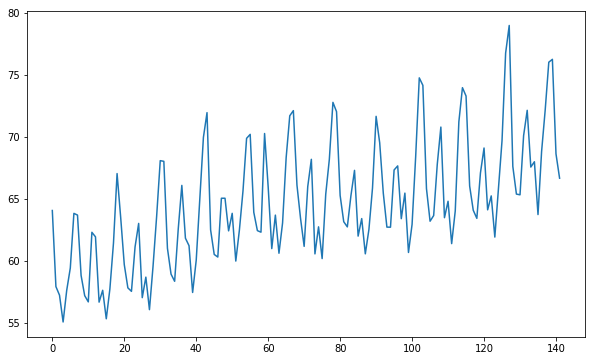

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6])
plt.plot(our_result)

**Вывод**: получили график после преобразования, дисперсия стала более стабильной, но нужно продифференцировать ряд.

## 3б. Дифференцирование ряда

Идея группировать данные кажется хорошей:

In [24]:
df['oxcox'] = our_result

In [25]:
df.head()

The total generation of electricity      oxcox
Month                                                     
1985-01-01                               227.86  64.053144
1985-02-01                               198.24  57.921415
1985-03-01                               194.97  57.228524
1985-04-01                               184.88  55.068610
1985-05-01                               196.79  57.614587

In [26]:
mean_elec = df.groupby([df.index.year, df.index.month])[df.columns[1]].mean()

mean_elec.head()

Month  Month
1985   1        64.053144
       2        57.921415
       3        57.228524
       4        55.068610
       5        57.614587
Name: oxcox, dtype: float64

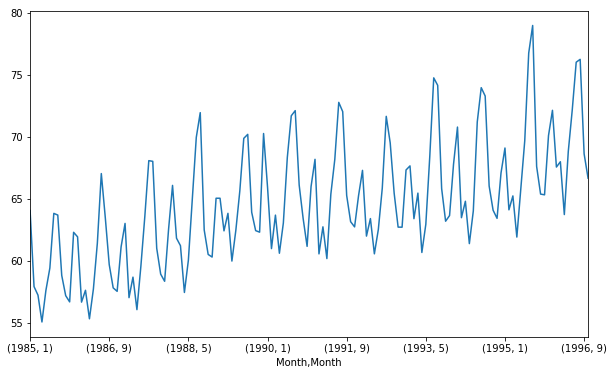

In [27]:
mean_elec.plot(figsize=(10, 6))
plt.show()

Сезонный лаг около 12 месяцев. Сначала просто продифференцируем, а потом с сезонным лагом

## 4

Сезонный лаг около 12 месяцев. Сначала просто продифференцируем, а потом с сезонным лагом

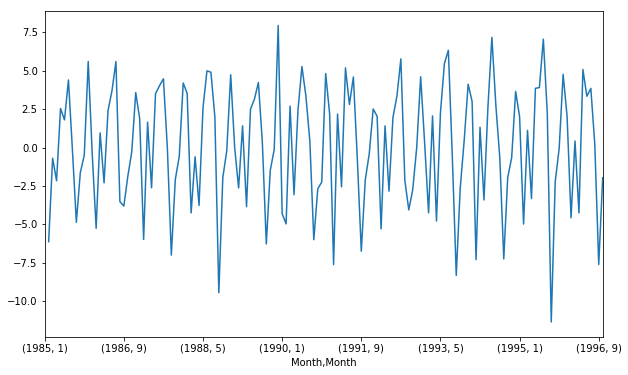

In [28]:
mean_elec.diff().plot(figsize=(10, 6))
plt.show()

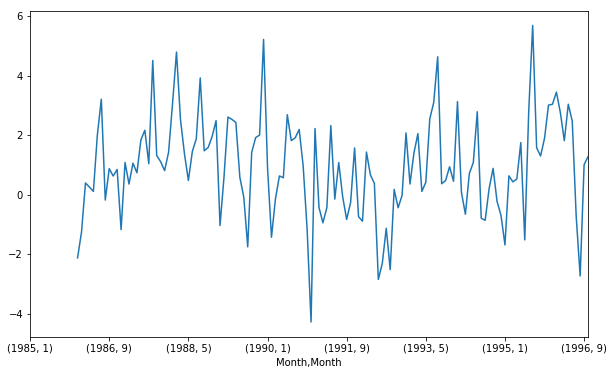

In [29]:
mean_elec.diff(12).plot(figsize=(10, 6))
plt.show()

С сезонным лагом кажется лучше получилось преобразование, проверим с помощью автокорреляций

In [30]:
diff_without_lag = mean_elec.diff()

diff_without_lag.head()

Month  Month
1985   1             NaN
       2       -6.131730
       3       -0.692891
       4       -2.159914
       5        2.545977
Name: oxcox, dtype: float64

In [31]:
diff_without_lag = diff_without_lag.fillna(0)

c:\users\shiro\appdata\local\programs\python\python37\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


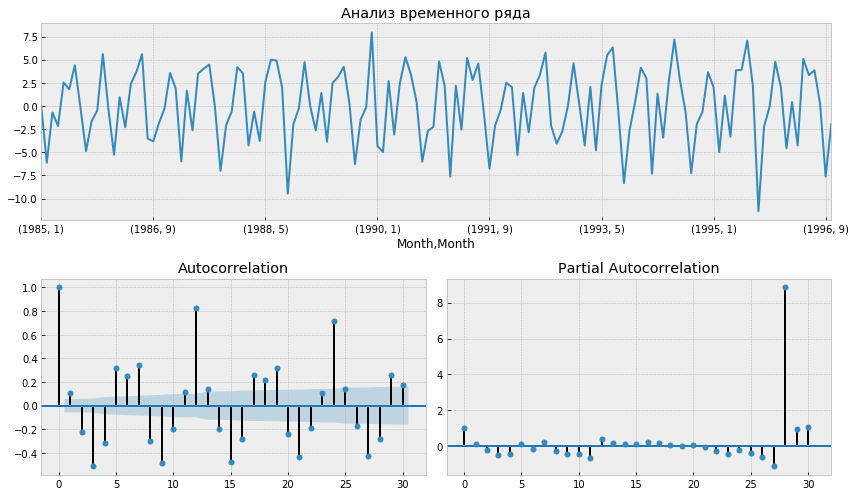

In [32]:
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Анализ временного ряда')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
    return 

tsplot(diff_without_lag, lags=30)

Автокорреляция неприятная, дифференцируем с лагом 12

In [33]:
diff_lag_12 = mean_elec.diff(12)

diff_lag_12.head(15)

Month  Month
1985   1             NaN
       2             NaN
       3             NaN
       4             NaN
       5             NaN
       6             NaN
       7             NaN
       8             NaN
       9             NaN
       10            NaN
       11            NaN
       12            NaN
1986   1       -2.122574
       2       -1.252650
       3        0.394536
Name: oxcox, dtype: float64

In [34]:
diff_lag_12= diff_lag_12.fillna(0)

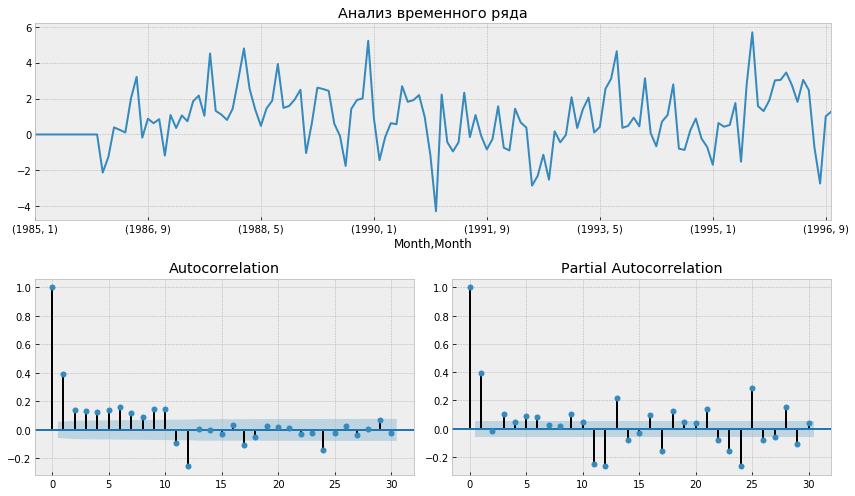

In [35]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Анализ временного ряда')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        plt.tight_layout()
    return 

tsplot(diff_lag_12, lags=30)

С помощью сезонной дифференцации получили стационарный ряд, практически убрали автокорреляцию

**Вывод**: c помощью преобразований получили стационарный ряд, мы избавились полностью от тренда

## 5 Перейдем к исходным данным

Сразу же отмечу, что вопрос про количество данных после преобразований в обратную сторону не понял, ведь если мы вернулись к исходному массиву, то и получили исходный, то есть правильный результат.

После преобразований дифференциации я понимаю, что потеряется данных, равное величине данных, но чтобы вернуться к исходному массиву значений мы должны эти данные в дифференцированный ряд искусственно вовлечь, так при `.diff` мы теряем информацию - первое, второе значение серии и.т.д 

Обратная функция к преобращванию Бокса-Кокса

In [36]:
def boxcox_inver(x, lmbda):
    if lmbda == 0:
        return exp(x)
    
    return exp( log ( lmbda * x + 1) / lmbda)

Заполнили искусственно потерянную информацию и вернулись после дифференциации

In [37]:
diff_without_lag.iat[0] = mean_elec.iat[0]
mean_elec_1 = diff_without_lag.cumsum()

mean_elec_1.head()

Month  Month
1985   1        64.053144
       2        57.921415
       3        57.228524
       4        55.068610
       5        57.614587
Name: oxcox, dtype: float64

Возвращаемся к исходным данным

In [38]:
after_changes = [boxcox_inver(x, my_lambda) for x in mean_elec_1]

after_changes

[227.85999999999996,
 198.24000000000012,
 194.97000000000008,
 184.88,
 196.79000000000005,
 205.35999999999999,
 226.72000000000003,
 226.05000000000007,
 202.50000000000009,
 194.79000000000005,
 192.43000000000006,
 219.24999999999994,
 217.47,
 192.33999999999997,
 196.82999999999996,
 186.07,
 197.31000000000003,
 215.01999999999998,
 242.66999999999996,
 225.17000000000007,
 206.69000000000003,
 197.74999999999986,
 196.43000000000004,
 213.54999999999993,
 222.75000000000006,
 194.03000000000006,
 201.85000000000005,
 189.49999999999997,
 206.06999999999994,
 225.59000000000003,
 247.9099999999999,
 247.64000000000019,
 213.00999999999993,
 203.00999999999996,
 200.2600000000001,
 220.5,
 237.89999999999995,
 216.94,
 214.0099999999999,
 196.00000000000009,
 208.36999999999998,
 232.74999999999997,
 257.4600000000001,
 267.69000000000005,
 220.17999999999992,
 210.61000000000013,
 209.58999999999997,
 232.74999999999997,
 232.74999999999997,
 219.82000000000005,
 226.7399999999

In [39]:
(after_changes - our_data) #разница между исходными величинами и после преобразования отсутствует.

array([-5.68434189e-14,  1.13686838e-13,  8.52651283e-14,  0.00000000e+00,
        5.68434189e-14, -2.84217094e-14,  2.84217094e-14,  5.68434189e-14,
        8.52651283e-14,  5.68434189e-14,  5.68434189e-14, -5.68434189e-14,
        0.00000000e+00, -2.84217094e-14, -5.68434189e-14,  0.00000000e+00,
        2.84217094e-14, -2.84217094e-14, -2.84217094e-14,  8.52651283e-14,
        2.84217094e-14, -1.42108547e-13,  2.84217094e-14, -8.52651283e-14,
        5.68434189e-14,  5.68434189e-14,  5.68434189e-14, -2.84217094e-14,
       -5.68434189e-14,  2.84217094e-14, -8.52651283e-14,  1.98951966e-13,
       -5.68434189e-14, -2.84217094e-14,  1.13686838e-13,  0.00000000e+00,
       -5.68434189e-14,  0.00000000e+00, -8.52651283e-14,  8.52651283e-14,
       -2.84217094e-14, -2.84217094e-14,  1.13686838e-13,  5.68434189e-14,
       -8.52651283e-14,  1.13686838e-13, -2.84217094e-14, -2.84217094e-14,
       -2.84217094e-14,  5.68434189e-14, -8.52651283e-14,  0.00000000e+00,
        8.52651283e-14, -

In [40]:
len(after_changes) == df.shape[0]

True

**Вывод**: вернулись к исходному ряду и наблюдений осталось такое же количество?